# 통계적 머신러닝을 통한 Kannada Digits 분류

본 파일은 고려대학교 통계학과 박유성교수님의 고급통계적 머신러닝의 기말 프로젝트의 주제로 다루었던 내용을 정리한 것이다. 
어떤 알고리듬이 더 나은가에 대해서 논의하기 보다는 한 주제를 가지고 다양한 알고리듬을 시도하는데 의의를 두었다. 
또한 랜덤시드가 동일 하지 않기에 결과와 텍스트상 약간의 차이가 있을 수 있다. 


---



본 프로젝트를 통해 숫자 이미지를 머신러닝 알고리듬을 통해 학습시켜 숫자 분류를 하고자 한다. 먼저 차원 축소를 통해 더 적은 수의 변수로 데이터의 많은 부분을 설명할 수 있도록 feature extraction을 하고자 한다. 또한, 각 모델에 대한 분류 정확도와 계산시간, 그리고 과적합 위험 정도에 초점을 맞추고 숫자 이미지 분류를 하는데 있어 통계적 머신러닝 모델을 비교할 것이다. 

In [3]:
## 이 부분은 해도 되고 안해도 된다.
# 코랩 구글 드라이브랑 연결하기

from google.colab import drive
drive.mount('/content/gdrive')

import os      # 디렉토리 설정
os.chdir("/content/gdrive/My Drive/Colab/Kannada-MNIST")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 1. 데이터 준비 

### 1-1 데이터에 대한 설명

일상적으로 익숙한 아라비아 숫자 분류를 할 수도 있지만, 좀 더 생소한 Kannada digits 를 분류해 보기로 한다. Kannada는 인도 서부의 Karnataka에 거주하는 사람들이 주로 사용하는 언어이며, 숫자 표기가 일상적으로 쓰이는 표기와 많이 다르기 때문에 좀 더 흥미로울 것이라고 생각했다. 데이터는 케글의 Kannada MNIST competition (https://www.kaggle.com/c/Kannada-MNIST) 에서의 데이터셋에서 찾을 수 있었다. 데이터의 형태를 다음과 같이 간략하게 살펴 볼 수 있다.

In [0]:
# 패키지 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# 데이터 불러오기 
data = pd.read_csv("train.csv")

In [7]:
print(data.shape)
data.head()

(60000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


데이터는 row 가 60000개, column이 785개였다. 한 개의 목적(target) 변수와 784개의 특성(feature) 변수 로 이루어져 있었으며, 각 feature variable 들이 28*28 = 784 사이즈의 픽셀들을 나타낸다는 것을 알 수 있었다. feature variable의 경우 0에서 255 까지의 값을 가지고 있었다.

다음 그림은 Kannada digits의 예시들이다. 차례로 0부터 9까지 나열했다. 

<Figure size 432x288 with 0 Axes>

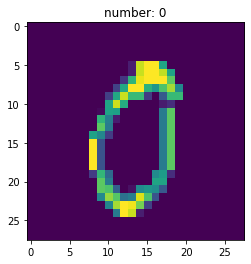

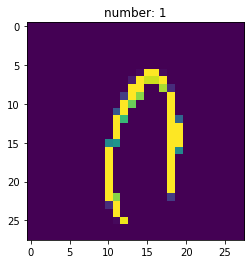

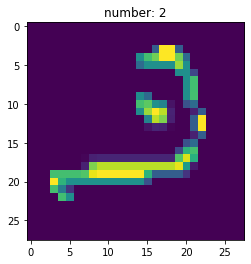

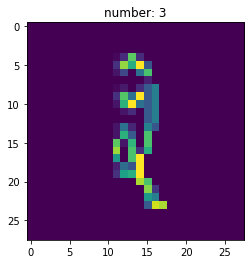

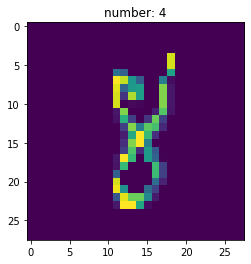

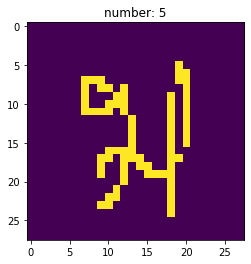

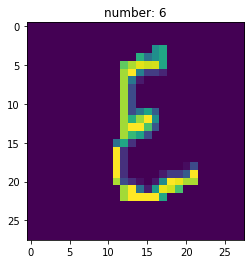

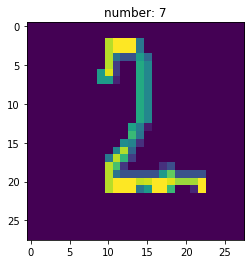

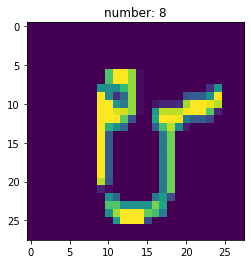

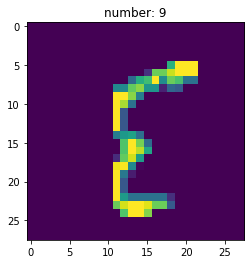

In [8]:
# 먼저 데이터를 피쳐변수와 타겟변수로 나눠 준다. 
X = data.drop('label', axis=1)
y=data['label'] 

X_img=X.values.reshape(-1,28,28,1)
plt.figure()
for i in range(1,11):
    plt.subplots(1,1,"row")
    plt.imshow(X_img[i-1][:,:,0])
    plt.title("number: %d" %(i-1))


또한 다음과 같이 트레인데이터에 존재하는 타겟변수의 빈도를 볼 수 있다. 

label
0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: label, dtype: int64


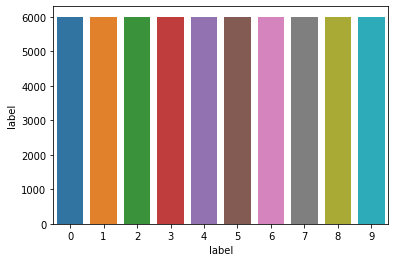

In [9]:
print(y.groupby(y).count())

sns.barplot(y.groupby(y).count().index, y.groupby(y).count())

Target variable(label) 의 경우 0에서 9까지의 값을 가지고 있었으며 각각 모두 6000개의 관측값을 균일하게 가지고 있었다.

본격적인 데이터 분석을 위해서 타겟변수에 대해서 원 핫 엔코딩을 하고, 훈련 데이터와 테스트 데이터를 7: 3 으로 나누어 주었다. (scaleling 적용)

참고 : 데이터를 학습하기에 앞서 반드시 스케일링을 적용해줘야 할 필요는 없다. 스케일링을 할시에 오히려 위치정보가 유실되어 모델의 성능이 떨어지는 경우도 있기 때문이다. 따라서 가장 좋은 방법은 스케일링을 적용한 모델과 적용하지 않은 모델을 생성하여 성능이 좋은 모델을 택하는 것이다. 다만 여기서는 특성변수들이 모두 동일한 성격(픽셀을 나타냄) 스케일을 하든 안하든 크게 차이가 나지 않을것이라 예상하여 스케일링을 적용한 모델만을 만들었다. 

In [0]:
# 원 핫 엔코딩
from sklearn.preprocessing import LabelEncoder
classle=LabelEncoder()
y=classle.fit_transform(data['label'].values) 

#train 데이터와 test 데이터를 7:3 으로 나누어줌 
from sklearn.model_selection import train_test_split 
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.3, random_state=1, stratify=y)

# 스케일링 적용 
from sklearn.preprocessing import StandardScaler
std=StandardScaler()
X_train_std=std.fit_transform(X_train)
X_test_std=std.transform(X_test)

### 1-2 차원축소문제 

Kannada 데이터는 총 784개의 픽셀(특성변수)을 가지고 있으며, 이 모든 특성변수를 숫자를 분류하는 정보로서 이용하는 것은 불필요할 뿐더러 오히려 통계적 머신러닝 알고리듬의 성능을 낮출 수도 있다. 따라서 특성변수 대부분의 정보를 가진 새로운 특성변수를 추출하여 차원을 축소할 필요가 있다. 

####1-2-1.  Principal Component Analysis

먼저 PCA를 통한 차원축소를 위해 아이겐밸류를 구하고, 주성분들이 데이터의 전체 분산을 얼마만큼 설명할 수 있는지 알아보았으며, 결과는 다음과 같았다. 


/usr/local/lib/python3.6/dist-packages/matplotlib/transforms.py:796: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/matplotlib/transforms.py:796: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


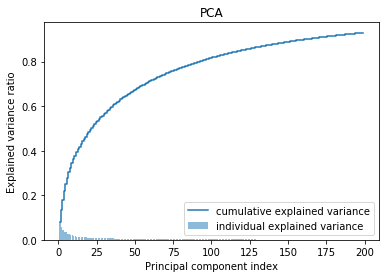

In [11]:
# PCA 
scov=np.cov(X_train.T)                     
eigen_vals, eigen_vecs=np.linalg.eig(scov)          

tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

import matplotlib.pyplot as plt
plt.bar(range(1,200), var_exp[0:199], alpha=0.5, align='center',label='individual explained variance')
plt.step(range(1,200), cum_var_exp[0:199], where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title("PCA")
plt.legend(loc='best')
plt.show()

변수의 개수가 많은 만큼 첫 10개 정도의 주성분을 제외하고는, 주성분들이 데이터의 전체 분산을 설명할 수 있는 정도가 매우 약했다. 첫 주성분 50개 까지는 사용해야 데이터 분산의 60% 이상 설명할 수 있었으며, 100 개 에 가깝게 사용하더라도 전체 데이터 분산의 80%도 설명할 수 없었다. 


첨언) Kernelized PCA를 쓸 수도 있겠지만, 이 데이터에 대해서는 메모리 문제로 인해 비효율적이라 느껴 쓰지 않았다. 


#### 1-2-2. Fisher’s Linear Discriminant Analysis

Fisher’s LDA의 경우에도 마찬가지로 새로운 특성변수를 생성하여, 이들이 전체 데이터의 얼마만큼 설명할 수 있는지 알아보았다. (9 차원을 형성함) 



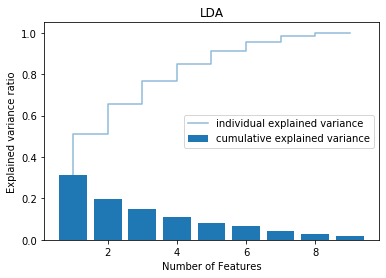

In [15]:
# LDA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda=LDA(n_components=9) # LDA에 n_components=9를 지정하면 LDA가 차원을 9로 줄여준다. 
X_train_lda=lda.fit_transform(X_train_std,y_train) 
X_test_lda=lda.transform(X_test_std)

lda_var=lda.explained_variance_ratio_
plt.step(range(1,10),np.cumsum(lda_var), alpha=0.5, label='individual explained variance')
plt.bar(range(1,10),height= lda_var,label='cumulative explained variance')
plt.title("LDA")
plt.ylabel('Explained variance ratio')
plt.xlabel('Number of Features')
plt.legend(loc="best")
plt.show()

PCA를 통한 차원축소와는 달리, Fisher’s LDA 차원축소를 통해 생성된 새로운 변수들은 전체 데이터 정보의 많은 부분을 설명할 수 있는 수준이었다. 첫 번째 변수만으로 31.1% 가량을 설명했으며, 첫 6개의 변수를 사용할 경우 91.4% 나 설명이 가능했다. 이는 Fisher’s LDA는 PCA 와는 달리 y의 정보를 이용하여 클래스를 잘 분류하는 벡터를 찾기 때문인듯 하다. 다음 표는 동일한 옵션에서 PCA와 Fisher’s LDA를 통해 얻은 새로운 변수로 몇몇 모델을 적합 시켰을 때 얻은 결과이다. (본 보고서에서의 계산시간은 훈련 셋을 통해 모델을 적합 시키고, 트레인 데이터와 테스트 데이터를 통해 예측까지 완료하는데 걸린 시간을 포함한다)

![대체 텍스트](https://drive.google.com/uc?id=1W-qx8PzjEef8vbeF5wydUYaaJX-FqeQD)


첨언) 계산속도를 높이기 위해 10개의 주성분만 사용할 경우, 대부분의 모델에서 90% 미만의 accuracy가 나왔기 때문에 accuracy를 어느정도 높일 수 있도록 주성분 개수를 25개로 잡았다.


모델을 적합 시키는데 포함된 변수의 수에 차이가 많음에도 불구하고 (PCA의 주성분 수를 크게 잡음), 모든 경우에서 accuracy의 차이는 크지 않았으며, Fisher’s LDA를 통해 만들어진 변수를 통해 모델을 적합 시키고, 클래스를 분류했을 때 계산 속도가 PCA의 경우보다 월등히 빨랐다. 따라서 Kannada 데이터 셋과 같이 특성변수의 수가 많은 상황에서(또는 target에 대한 정보가 있는 상황에서) 계산속도를 빠르게 하는 것이 목표라면 Fisher’s LDA를 사용하여 차원축소 하는 것이 적합해 보인다. 하지만 다소 시간이 걸리더라도 PCA를 통해 차원축소를 하여, 특성변수를 많이 사용하는 것이 더 적합한 경우 역시 있었다. (KNN의 경우가 그 예이다.)

분류 정확도도 중요하지만 계산 시간 역시 포기할 수 없는 부분이라고 생각했다. 따라서 본 프로젝트에서는 분류 정확도를 우선적으로 고려하되, 만일 두 차원축소 방법 간에 분류 정확도에 차이가 적을 시, 그리고 PCA에서 주성분 추가분에 대한 정분류율 상승이 거의 없을 시에, Fisher’s LDA 방법을 활용하여 차원축소를 하고, 모델을 튜닝하기로 했다. (두 차원 축소 방법의 분류적합도를 비교시에는 모형의 디폴트 옵션을 주었으며, 특성변수의 수는 최대 35개 까지만 고려하기로 했다. Fisher’s LDA방법을 쓴 경우 특성변수의 수를 35 까지 올린다고 해서 정분류율이 높아지지 않는다는 것을 관찰하여, 그래프에는 특성변수의 수 16개 까지만 플롯 했으며, PCA의 경우 특성변수 16개 까지 성능이 좋지 않을 경우 특성변수 수 20개부터 플롯 하였다.)


## 2.	통계적 머신러닝 모델의 적용

### 2-1 K-nearlest Neighbors(KNN)

다음 플롯을 통해 차원 축소를 통해 얻어진 새로운 변수 수에 따라 분류 정확도에 얼마나 많이 차이가 나는지에 대해 알 수 있다. 분류 모델로서 KNN 을 사용하였다.

(0.5, 1.0)

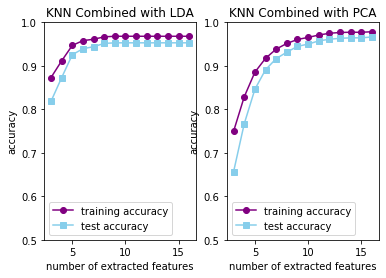

In [23]:
import warnings
warnings.filterwarnings(action='ignore')

#LDA
from sklearn.metrics import accuracy_score
max_depths = [3,4,5,6,7,8,9,10,11,12,13,14,15,16]
train_accu =[]
test_accu=[]

from sklearn.neighbors import KNeighborsClassifier

for i in max_depths:
    lda=LDA(n_components=i)
    X_train_lda=lda.fit_transform(X_train_std,y_train) 
    X_test_lda=lda.transform(X_test_std) 
    knn=KNeighborsClassifier(n_neighbors=5,p=2)
    knn.fit(X_train_lda, y_train)
    y_train_pred=knn.predict(X_train_lda) 
    y_test_pred=knn.predict(X_test_lda)
    train_accu.append(accuracy_score(y_train, y_train_pred))
    test_accu.append(accuracy_score(y_test, y_test_pred))

plt.figure()
plt.subplot(1,2,1)
plt.plot(range(3,17), train_accu, color="purple", marker='o', label="training accuracy")
plt.plot(range(3,17), test_accu, color="skyblue", marker='s', label ="test accuracy")
plt.legend(loc="best")
plt.ylabel("accuracy")
plt.xlabel("number of extracted features")
plt.title("Combined with Fisher's LDA")
plt.ylim(0.5, 1.0)

#PCA

from sklearn.metrics import accuracy_score
max_depths = [3,4,5,6,7,8,9,10,11,12,13,14,15,16]
train_accu =[]
test_accu=[]

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

for i in max_depths:
    pca= PCA(n_components=i) 
    X_train_pca=pca.fit_transform(X_train_std,y_train) 
    X_test_pca=pca.transform(X_test_std) 
    knn=KNeighborsClassifier(n_neighbors=5,p=2)
    knn.fit(X_train_pca, y_train)
    y_train_pred=knn.predict(X_train_pca) 
    y_test_pred=knn.predict(X_test_pca)
    train_accu.append(accuracy_score(y_train, y_train_pred))
    test_accu.append(accuracy_score(y_test, y_test_pred))

plt.subplot(1,2,2)    
plt.plot(range(3,17), train_accu, color="purple", marker='o', label="training accuracy")
plt.plot(range(3,17), test_accu, color="skyblue", marker='s', label ="test accuracy")
plt.legend(loc="best")
plt.ylabel("accuracy")
plt.xlabel("number of extracted features")
plt.title("Combined with PCA")
plt.ylim(0.5, 1.0)



위의 두 플롯을 통해 알 수 있듯이, Fisher’s LDA를 통해 차원 축소를 한 경우 새로운 특성변수를 추가 함으로서 얻는 분류 정확도의 추가분은 한계가 있어 보인다. (7개의 변수를 썼을 때부터 분류 정확도의 상승이 없었다.) 하지만 PCA를 통해 얻어진 주성분을 통해 KNN 모델을 적합 시킨 경우, 느리긴 하지만 분류 정확도가 확실히 상승을 하고 있다는 것을 알 수 있었다. 

따라서 KNN의 경우에는 PCA를 통해 차원축소를 하도록 한다. 다음의 코드를 통해 cross validation 을 해본 결과 다음과 같은 최적 파라미터를 찾을 수 있었다. (차원은 35개로 줄임)


In [24]:
from sklearn.decomposition import PCA

pca=PCA(n_components=35) 
X_train_pca=pca.fit_transform(X_train_std,y_train) 
X_test_pca=pca.transform(X_test_std) 

from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier 
knn=KNeighborsClassifier(p=2) 

param_range = [3,4,5,6,7,8,9,10]
param_grid = [{'n_neighbors': param_range, 'weights': ["distance"]},
             {'n_neighbors': param_range, 'weights': ["uniform"]}]   
gs = GridSearchCV(estimator=knn, param_grid=param_grid,
                  scoring='accuracy', cv=10)

gs = gs.fit(X_train_pca, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9801428571428572
{'n_neighbors': 4, 'weights': 'distance'}


In [25]:
import time
start = time.time() 

clf = gs.best_estimator_
clf.fit(X_train_lda, y_train)
print("train accuracy : ",clf.score(X_train_lda,y_train))
print("test accuracy : ", clf.score(X_test_lda, y_test))

print("time :", time.time() - start)

train accuracy :  1.0
test accuracy :  0.9675
time : 12.80156922340393


관측치에 대한 weight 를 uniform 하게 보다는 거리에 반비례 하게 주는 것이 좀더 분류 정확도를 높일 수 있었으며, 계산시간에 비해 분류정확도(96.75%)가 높은 편이었다. 과적합 문제가 다소 있는 편이었다. 

### 2-2 Logistic Regression Classifier

(0.5, 1.0)

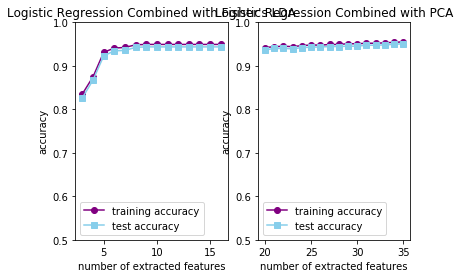

In [26]:
#LDA

from sklearn.metrics import accuracy_score
max_depths = [3,4,5,6,7,8,9,10,11,12,13,14,15,16]
train_accu =[]
test_accu=[]

from sklearn.linear_model import LogisticRegression

for i in max_depths:
    lda=LDA(n_components=i) 
    X_train_lda=lda.fit_transform(X_train_std,y_train) 
    X_test_lda=lda.transform(X_test_std) 
    Logit = LogisticRegression(C=1e2, random_state=1)
    Logit.fit(X_train_lda, y_train)
    y_train_pred=Logit.predict(X_train_lda) 
    y_test_pred=Logit.predict(X_test_lda)
    train_accu.append(accuracy_score(y_train, y_train_pred))
    test_accu.append(accuracy_score(y_test, y_test_pred))


plt.figure()
plt.subplot(1,2,1)

plt.plot(range(3,17), train_accu, color="purple", marker='o', label="training accuracy")
plt.plot(range(3,17), test_accu, color="skyblue", marker='s', label ="test accuracy")
plt.legend(loc="best")
plt.ylabel("accuracy")
plt.xlabel("number of extracted features")
plt.title("Combined with Fisher's LDA")
plt.ylim(0.5, 1.0)

#PCA
from sklearn.metrics import accuracy_score
max_depths = range(20,36)
train_accu =[]
test_accu=[]

from sklearn.linear_model import LogisticRegression

for i in max_depths:
    pca=PCA(n_components=i) 
    X_train_pca=pca.fit_transform(X_train_std,y_train) 
    X_test_pca=pca.transform(X_test_std) 
    Logit = LogisticRegression(C=1e2, random_state=1)
    Logit.fit(X_train_pca, y_train)
    y_train_pred=Logit.predict(X_train_pca) 
    y_test_pred=Logit.predict(X_test_pca)
    train_accu.append(accuracy_score(y_train, y_train_pred))
    test_accu.append(accuracy_score(y_test, y_test_pred))

plt.subplot(1,2,2)
plt.plot(range(20,36), train_accu, color="purple", marker='o', label="training accuracy")
plt.plot(range(20,36), test_accu, color="skyblue", marker='s', label ="test accuracy")
plt.legend(loc="best")
plt.ylabel("accuracy")
plt.xlabel("number of extracted features")
plt.title("Combined with PCA")
plt.ylim(0.5, 1.0)

Logistic Regression Classifer 의 경우에는 두 차원 축소 방법의 정 분류율의 차이가 거의 나지 않아 Fisher’s LDA를 사용하도록 하겠다(n_components=9). 주목할 점은 Logistic Regression Classifier 에서는 과적합문제가 거의 발생하지 않았다는 것이다. 

Logistic Regression Classifier에서는 다양한 solver 를 사용할 수 있었으며, 각 solver마다 사용해야 하는 상황이나 사용 가능한 penalty 옵션이 모두 다르다. 따라서 각각의 solver 에 대해 cross validation을 통한 각각의 best parameter와 best score를 다음과 같이 찾아보았다.

##### 생략 

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda=LDA(n_components=9) # LDA에 n_components=2를 지정하면 LDA가 차원을 2로 줄여준다. 
X_train_lda=lda.fit_transform(X_train_std,y_train) # wine data에 의해 뽑힘.
X_test_lda=lda.transform(X_test_std) 

Liblinear solver

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
Logit = LogisticRegression(solver = "liblinear",multi_class= "auto", random_state=1)


param_range = [0.001,0.01,0.1,1,100,100]
param_grid = [{'C': param_range, 'penalty': ["l1","l2"]}]    # C--> error를 얼마나 허용할거냐,, 이걸 pram_range 에서 찾아라  #리니어 할거냐 커넬 할거냐 이런것도 가능해용 // 
gs = GridSearchCV(estimator=Logit, param_grid=param_grid,   #판별방법 아큐러씨로 가장 옵티멀 한거 찾아용
                  #MAE로 하세용 (아큐러시로 할때는 표준화가 되야 한대 (즉 샘플 사이즈에 의존하지 않아야 한단거임  16분 들으세용 )
                  scoring='accuracy', cv=10)

gs = gs.fit(X_train_lda, y_train)
print("best accuracy : ", gs.best_score_)
print("best parameter : ", gs.best_params_)

#l1 은 멀티노미어 지원이 되지 않아 오토로 바꿔줌

best accuracy :  0.9399285714285714
best parameter :  {'C': 100, 'penalty': 'l1'}


In [29]:
import time
start = time.time() 

clf = gs.best_estimator_
clf.fit(X_train_lda, y_train)
print("train accuracy : ", clf.score(X_train_lda,y_train))
print("test accuracy : ", clf.score(X_test_lda, y_test))

print("time :", time.time() - start)

train accuracy :  0.939952380952381
test accuracy :  0.9361666666666667
time : 1.3683481216430664


newton-cg

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
Logit = LogisticRegression(solver = "newton-cg",multi_class= "multinomial", random_state=1)


param_range = [0.001,0.01,0.1,1,100,100]
param_grid = [{'C': param_range, 'penalty': ["l2"]}]    # C--> error를 얼마나 허용할거냐,, 이걸 pram_range 에서 찾아라  #리니어 할거냐 커넬 할거냐 이런것도 가능해용 // 
gs = GridSearchCV(estimator=Logit, param_grid=param_grid,   #판별방법 아큐러씨로 가장 옵티멀 한거 찾아용
                  #MAE로 하세용 (아큐러시로 할때는 표준화가 되야 한대 (즉 샘플 사이즈에 의존하지 않아야 한단거임  16분 들으세용 )
                  scoring='accuracy', cv=10)

gs = gs.fit(X_train_lda, y_train)
print("best accuracy :", gs.best_score_)
print("best parameter :",gs.best_params_)

best accuracy : 0.9489047619047619
best parameter : {'C': 100, 'penalty': 'l2'}


In [31]:
import time
start = time.time() 


clf = gs.best_estimator_
clf.fit(X_train_lda, y_train)
print("train accuracy : ", clf.score(X_train_lda,y_train))
print("test accuracy : ", clf.score(X_test_lda, y_test))

print("time :", time.time() - start)

train accuracy :  0.9492857142857143
test accuracy :  0.9436111111111111
time : 3.9187111854553223


lbfgs 

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
Logit = LogisticRegression(solver = "lbfgs",multi_class= "multinomial", random_state=1, max_iter = 1000)


param_range = [0.001,0.01,0.1,1,100,100]
param_grid = [{'C': param_range, 'penalty': ["l2"]}]    # C--> error를 얼마나 허용할거냐,, 이걸 pram_range 에서 찾아라  #리니어 할거냐 커넬 할거냐 이런것도 가능해용 // 
gs = GridSearchCV(estimator=Logit, param_grid=param_grid,   #판별방법 아큐러씨로 가장 옵티멀 한거 찾아용
                  #MAE로 하세용 (아큐러시로 할때는 표준화가 되야 한대 (즉 샘플 사이즈에 의존하지 않아야 한단거임  16분 들으세용 )
                  scoring='accuracy', cv=10)

gs = gs.fit(X_train_lda, y_train)
print("best accuracy : ", gs.best_score_)
print("best parameter : ", gs.best_params_)

best accuracy :  0.9489047619047619
best parameter :  {'C': 100, 'penalty': 'l2'}


In [33]:
import time
start = time.time() 


clf = gs.best_estimator_
clf.fit(X_train_lda, y_train)
print("train accuracy : ", clf.score(X_train_lda,y_train))
print("test accuracy : " , clf.score(X_test_lda, y_test))

print("time :", time.time() - start)

train accuracy :  0.9492857142857143
test accuracy :  0.9436111111111111
time : 4.556284427642822


sag

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
Logit = LogisticRegression(solver = "sag",multi_class= "multinomial", random_state=1)


param_range = [0.001,0.01,0.1,1,100,100]
param_grid = [{'C': param_range, 'penalty': ["l2"]}]    # C--> error를 얼마나 허용할거냐,, 이걸 pram_range 에서 찾아라  #리니어 할거냐 커넬 할거냐 이런것도 가능해용 // 
gs = GridSearchCV(estimator=Logit, param_grid=param_grid,   #판별방법 아큐러씨로 가장 옵티멀 한거 찾아용
                  #MAE로 하세용 (아큐러시로 할때는 표준화가 되야 한대 (즉 샘플 사이즈에 의존하지 않아야 한단거임  16분 들으세용 )
                  scoring='accuracy', cv=10)

gs = gs.fit(X_train_lda, y_train)
print("best accuracy : ", gs.best_score_)
print("best parameter : ", gs.best_params_)

best accuracy :  0.9489047619047619
best parameter :  {'C': 100, 'penalty': 'l2'}


In [35]:
import time
start = time.time() 


clf = gs.best_estimator_
clf.fit(X_train_lda, y_train)
print("train accuracy : ", clf.score(X_train_lda,y_train))
print("test accuracy : ",clf.score(X_test_lda, y_test))
print("time :", time.time() - start)

train accuracy :  0.9492619047619048
test accuracy :  0.9436111111111111
time : 1.142254114151001


saga 

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
Logit = LogisticRegression(solver = "saga",multi_class= "multinomial", random_state=1,max_iter = 1000)


param_range = [0.001,0.01,0.1,1,100,100]
param_grid = [
             {'C': param_range, 'penalty': ["elasticnet"], "l1_ratio":[0.2,0.4,0.5,0.8,1]}]    # C--> error를 얼마나 허용할거냐,, 이걸 pram_range 에서 찾아라  #리니어 할거냐 커넬 할거냐 이런것도 가능해용 // 
gs = GridSearchCV(estimator=Logit, param_grid=param_grid,   #판별방법 아큐러씨로 가장 옵티멀 한거 찾아용
                  #MAE로 하세용 (아큐러시로 할때는 표준화가 되야 한대 (즉 샘플 사이즈에 의존하지 않아야 한단거임  16분 들으세용 )
                  scoring='accuracy', cv=10)

gs = gs.fit(X_train_lda, y_train)
print("best accuracy : ", gs.best_score_)
print("best parameter : ", gs.best_params_)

best accuracy :  0.9489047619047619
best parameter :  {'C': 1, 'l1_ratio': 0.8, 'penalty': 'elasticnet'}


In [37]:
import time
start = time.time() 


clf = gs.best_estimator_
clf.fit(X_train_lda, y_train)
print(clf.score(X_train_lda,y_train))
print(clf.score(X_test_lda, y_test))

print("time :", time.time() - start)

0.9493095238095238
0.9435
time : 13.936273574829102


##### 결과를 정리하면 다음과 같다.

![solver 비교](https://drive.google.com/uc?id=1FLydhnE8iq2NUQXR4Gp0WPQ-bmpOtnQ2)

(random seed 값이 달라서 다소 차이가 있을 수 있다.)

정분류율의 경우 train 셋과 test 셋의 Accuracy 93%, 94% 정도에서 solver에 관계없이 비슷한 수준이었다. (liblinear 에서는 test accuracy와 test accuracy가 다소 낮았다.) 하지만 계산시간에 있어서는 많은 차이가 났다. 가장 빨랐던 sag solver 의 경우 2초 미만 정도로 빠른 계산이 가능했으며, 이는 sag solver 가 큰 사이즈의 데이터 셋에 적합하다는 기존 지식과 동일한 결과이다. 하지만 saga solver 에서는 오히려 계산시간이 늘어났다. 
(특히 lbfgs와 saga solver로 Cross validation을 할 때, max_iter =100 디폴트 값으로 학습을 시킬 경우 convergence 가 실패 했다는 에러메시지가 발생하였다.)
첨언) multi_class 옵션의 경우 liblinear solver의 경우에만 “auto”로 주었고 나머지 경우에는 “multinomial”로 주었다. 또한 penalty의 경우 liblinear와 saga 만 L1 penalty 가 가능하였고, 특히 saga solver에서만 elasticnet 패널티가 가능했다. 
# 새 섹션


### 2-3 Linear Discriminant Analysis(LDA) 와 Quadratic Discriminant Analysis(QDA)

LDA와 QDA를 한번에 비교해 보도록 하겠다. 이 경우에는 따로 차원 축소 방법을 비교하지 않았다. 다음은 6차원으로 축소했을 때의 결과이다. (6개의 변수로 데이터의 90% 이상을 설명할 수 있었으며, n_component를 높게 주더라도 분류율에 의미 있는 변화가 없었다.) Linear Discriminant Analysis의 경우 “lsqr”, “eigen”, 그리고 “svd” solver 옵션이 있었다. “lsqr”과 “eigen” solver의 경우 shrinkage 옵션을 줄 수 있었지만(“auto”로 지정했다.) “svd”의 경우에 호환되지 않는다.

##### 생략 

 LDA : eigen solver 

In [47]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda=LDA(n_components=6) # LDA에 n_components=2를 지정하면 LDA가 차원을 2로 줄여준다. 
X_train_lda=lda.fit_transform(X_train_std,y_train) # wine data에 의해 뽑힘.
X_test_lda=lda.transform(X_test_std) 

from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda=LDA()

#param_range = [0.001,0.01,0.1,1,100,100]
param_grid = [{"solver" : ["eigen"],"shrinkage" : [None, "auto"]}]    
gs = GridSearchCV(estimator=lda, param_grid=param_grid, scoring='accuracy', cv=10)

gs = gs.fit(X_train_lda, y_train)
print("best accuracy : " , gs.best_score_)
print("best parameter : ", gs.best_params_)

best accuracy :  0.924952380952381
best parameter :  {'shrinkage': 'auto', 'solver': 'eigen'}


In [48]:
import time
start = time.time() 


clf = gs.best_estimator_
clf.fit(X_train_lda, y_train)
print("train accuracy : ", clf.score(X_train_lda,y_train))
print("test accuracy : " ,clf.score(X_test_lda, y_test))

print("time : ", time.time() - start)

train accuracy :  0.9251190476190476
test accuracy :  0.9184444444444444
time :  0.08689618110656738


LDA : slqr solver 

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda=LDA()

#param_range = [0.001,0.01,0.1,1,100,100]
param_grid = [{"solver" : ["lsqr"],"shrinkage" : [None, "auto"]}]    
gs = GridSearchCV(estimator=lda, param_grid=param_grid, scoring='accuracy', cv=10)

gs = gs.fit(X_train_lda, y_train)
print("best accuracy : " , gs.best_score_)
print("best parameter : ", gs.best_params_)

best accuracy :  0.924952380952381
best parameter :  {'shrinkage': 'auto', 'solver': 'lsqr'}


In [50]:
import time
start = time.time() 


clf = gs.best_estimator_
clf.fit(X_train_lda, y_train)
print("train accuracy : ", clf.score(X_train_lda,y_train))
print("test accuracy : " ,clf.score(X_test_lda, y_test))

print("time : ", time.time() - start)

train accuracy :  0.9251190476190476
test accuracy :  0.9184444444444444
time :  0.06810593605041504


LDA :  svd solver 

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda=LDA()

#param_range = [0.001,0.01,0.1,1,100,100]
param_grid = [{"solver" : ["svd"]}]
gs = GridSearchCV(estimator=lda, param_grid=param_grid, scoring='accuracy', cv=10)

gs = gs.fit(X_train_lda, y_train)
print("best accuracy : ",gs.best_score_)
print("best parameter : " ,gs.best_params_)

best accuracy :  0.9248809523809525
best parameter :  {'solver': 'svd'}


In [52]:
import time
start = time.time() 


clf = gs.best_estimator_
clf.fit(X_train_lda, y_train)
print("train accuracy : ",clf.score(X_train_lda,y_train))
print("test accuracy : ", clf.score(X_test_lda, y_test))

print("time :", time.time() - start)

train accuracy :  0.9250714285714285
test accuracy :  0.9184444444444444
time : 0.06349349021911621


QDA

In [53]:
import time
start = time.time() 
# Logistic regression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
cqd=QuadraticDiscriminantAnalysis(store_covariance=True)
cqd.fit(X_train_lda,y_train)
print("time :", time.time() - start)

time : 0.02606368064880371


In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
cqd=QuadraticDiscriminantAnalysis()

param_range = [0.001,0.01,0.1,1,100,100]
param_grid = [
             {'C': param_range, 'penalty': ["elasticnet"], "l1_ratio":[0.2,0.4,0.5,0.8,1]}]    # C--> error를 얼마나 허용할거냐,, 이걸 pram_range 에서 찾아라  #리니어 할거냐 커넬 할거냐 이런것도 가능해용 // 
gs = GridSearchCV(estimator=Logit, param_grid=param_grid,   #판별방법 아큐러씨로 가장 옵티멀 한거 찾아용
                  #MAE로 하세용 (아큐러시로 할때는 표준화가 되야 한대 (즉 샘플 사이즈에 의존하지 않아야 한단거임  16분 들으세용 )
                  scoring='accuracy', cv=10)

gs = gs.fit(X_train_lda, y_train)
print("best accuracy : ",gs.best_score_)
print("best parameter : " ,gs.best_params_)

best accuracy :  0.9408809523809525
best parameter :  {'C': 1, 'l1_ratio': 0.5, 'penalty': 'elasticnet'}


In [55]:
import time
start = time.time() 


clf = gs.best_estimator_
clf.fit(X_train_lda, y_train)
print("train accuracy : ", clf.score(X_train_lda,y_train))
print("test accuracy : ",clf.score(X_test_lda, y_test))

print("time :", time.time() - start)

train accuracy :  0.9409285714285714
test accuracy :  0.9345
time : 12.876290798187256


##### 결과 정리 (랜덤시드와 다른 환경때문에 다소 차이가 있을 수 있음)

![결과](https://drive.google.com/uc?id=1-4huVM5OxJIgl2wVqfGD7DEurRXTzgPd)


LDA의 경우에 세 가지 종류의 solver 모두 거의 동일한 train과 test 분류 정확도를 보였다. 하지만 계산 속도에서 약간의 차이가 난다는 사실을 알 수 있었는데, svd의 경우 계산 시간이 가장 적게 소요 되었다. 가장 높은 정 분류율을 보인 것은 QDA를 통한 분류였으며, 이 데이터에서는 QDA가 좀 더 우수한 성능을 보였다고 생각한다. 과적합이 1%내로 발생함을 관찰했다. 하지만 계산시간이 LDA 보다는 훨씬 오래걸렸다.

### 2-4 Naïve Bayes Model

(0.5, 1.0)

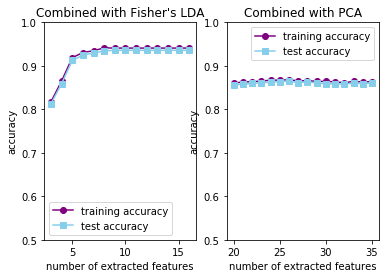

In [56]:
#LDA

from sklearn.metrics import accuracy_score
max_depths = [3,4,5,6,7,8,9,10,11,12,13,14,15,16]
train_accu =[]
test_accu=[]

from sklearn.naive_bayes import GaussianNB
gnb=GaussianNB()
for i in max_depths:
    lda=LDA(n_components=i)
    X_train_lda=lda.fit_transform(X_train_std,y_train) 
    X_test_lda=lda.transform(X_test_std) 
    gnb.fit(X_train_lda, y_train)
    y_train_pred=gnb.predict(X_train_lda) 
    y_test_pred=gnb.predict(X_test_lda)
    train_accu.append(accuracy_score(y_train, y_train_pred))
    test_accu.append(accuracy_score(y_test, y_test_pred))
    
plt.figure()
plt.subplot(1,2,1)
plt.plot(range(3,17), train_accu, color="purple", marker='o', label="training accuracy")
plt.plot(range(3,17), test_accu, color="skyblue", marker='s', label ="test accuracy")
plt.legend(loc="best")
plt.ylabel("accuracy")
plt.xlabel("number of extracted features")
plt.title("Combined with Fisher's LDA")
plt.ylim(0.5, 1.0)


#PCA 

from sklearn.metrics import accuracy_score
max_depths = range(20,36)
train_accu =[]
test_accu=[]

from sklearn.naive_bayes import GaussianNB
gnb=GaussianNB()
for i in max_depths:
    pca=PCA(n_components=i) 
    X_train_pca=pca.fit_transform(X_train_std,y_train) 
    X_test_pca=pca.transform(X_test_std) 
    gnb.fit(X_train_pca, y_train)
    y_train_pred=gnb.predict(X_train_pca) 
    y_test_pred=gnb.predict(X_test_pca)
    train_accu.append(accuracy_score(y_train, y_train_pred))
    test_accu.append(accuracy_score(y_test, y_test_pred))

plt.subplot(1,2,2)

plt.plot(range(20,36), train_accu, color="purple", marker='o', label="training accuracy")
plt.plot(range(20,36), test_accu, color="skyblue", marker='s', label ="test accuracy")
plt.legend(loc="best")
plt.ylabel("accuracy")
plt.xlabel("number of extracted features")
plt.title("Combined with PCA")
plt.ylim(0.5, 1.0)

플롯에서 알 수 있듯이, 학습할 주성분의 개수를 많이 늘리더라도, LDA를 통한 차원 축소가 나이브 베이즈 모델에서 성능이 월등히 좋았다는 것을 알 수 있었다. 또한 나이브 베이즈 모델에서는 과적합 문제가 적었다는 점을 주목했다. 

더불어 나이브 베이즈 모델의 경우, 특성변수의 차원이 커지더라도 꽤 빠른 속도로 분류가 수행되는 경험을 여럿 해본적이 있었다. 따라서 특성변수의 차원축소를 하지 않고 분류했을 경우와, 특성변수의 차원축소를 한 경우의 분류를 비교해 보았다.


##### 생략

차원 축소를 거치지 않았을 경우 

In [57]:
import time
start = time.time() 

from sklearn.naive_bayes import GaussianNB
gnb=GaussianNB()
gnb.fit(X_train, y_train)
print("time :", time.time() - start)


start = time.time() 

y_train_pred=gnb.predict(X_train)
y_test_pred=gnb.predict(X_test)

print("time :", time.time() - start)

time : 0.7776970863342285
time : 2.738884210586548


In [58]:
from sklearn.metrics import accuracy_score
print("train accuracy :" ,accuracy_score(y_train, y_train_pred)) # train data에 대한 accuracy
print("test accuracy :", accuracy_score(y_test, y_test_pred)) # test data에 대한 accuracy

# 분류 결과
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_test_pred))  

train accuracy : 0.7266666666666667
test accuracy : 0.7201111111111111
[[1025   45    6  140  558   17    0    0    9    0]
 [  16 1387    0   50  336    9    0    0    0    2]
 [   5    0 1778    5    1    8    0    0    3    0]
 [   1    1    3 1261  460   11   46   15    0    2]
 [   0    0    1   15 1753   17    0    0    6    8]
 [   3    3    8  337  288 1151    0    1    3    6]
 [   1    0    0  180   22    0 1585   11    1    0]
 [   0    2    1  765  124    4  697  200    2    5]
 [  44    1    7    5  127   17    1    0 1560   38]
 [   0    0    5   20  491    4    5    0   13 1262]]


Fisher's LDA 를 통한 차원축소를 거친 경우 

In [59]:
import time
start = time.time() 
# Logistic regression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
cld=LinearDiscriminantAnalysis(store_covariance=True)
cld.fit(X_train_lda, y_train) # LDA 적합
print("time :", time.time() - start)

time : 0.07499814033508301


In [60]:
import time
start = time.time() 

y_train_pred=cld.predict(X_train_lda)
y_test_pred=cld.predict(X_test_lda)
print("time :", time.time() - start)

time : 0.013744831085205078


In [61]:
from sklearn.metrics import accuracy_score
print("train accuracy : ", accuracy_score(y_train, y_train_pred)) # train data에 대한 accuracy
print("test accuracy : ", accuracy_score(y_test, y_test_pred)) # test data에 대한 accuracy

# 분류 결과
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_test_pred)) 

train accuracy :  0.9351904761904762
test accuracy :  0.9307222222222222
[[1707   56    2   13    2    0    2   10    8    0]
 [  12 1748    3   20    2    7    1    3    0    4]
 [  25    2 1737   13    1   22    0    0    0    0]
 [  24    2    0 1647   35   13   12   67    0    0]
 [   4    0    0   17 1745   23    0    7    0    4]
 [   1    9   17   16   55 1688    1    5    8    0]
 [   0    0    0   26    4    0 1612  156    2    0]
 [   9    1    0  107   25    3  149 1506    0    0]
 [  67    4    3    6   14    6    1    0 1687   12]
 [   6    1    0    5   46    1   11   32   22 1676]]


##### 결과

![결과](https://drive.google.com/uc?id=16MNXtLLNlSur0vjuxmYBWSYlyc3fGdD4)

차원 축소를 하지 않은 경우, 차원 축소를 했을 때 보다 오히려 분류 정확도가 상당히 낮아지는 것을 볼 수 있었다. 모델을 적합시킬 때 중요한 것은 변수의 개수가 아닌 설명력이며, 따라서 Kannada digits 데이터와 같이 특성 변수의 차원이 큰 경우 적당한 수준의 차원 축소는 필수적이란 사실을 알 수 있었다. 

### 2-5 Classification Tree  

(0.5, 1.0)

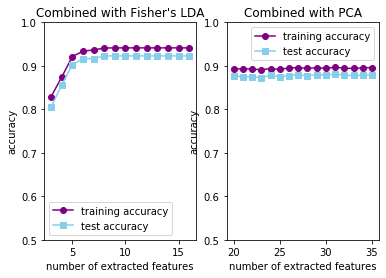

In [67]:
#LDA
from sklearn.metrics import accuracy_score
max_depths = [3,4,5,6,7,8,9,10,11,12,13,14,15,16]
train_accu =[]
test_accu=[]

from sklearn import tree  # 또는 from sklearn import DecisionTreeClassifier
dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth=8, random_state=1)

for i in max_depths:
    lda=LDA(n_components=i) 
    X_train_lda=lda.fit_transform(X_train_std,y_train) 
    X_test_lda=lda.transform(X_test_std) 
    dtc.fit(X_train_lda, y_train)
    y_train_pred=dtc.predict(X_train_lda) 
    y_test_pred=dtc.predict(X_test_lda)
    train_accu.append(accuracy_score(y_train, y_train_pred))
    test_accu.append(accuracy_score(y_test, y_test_pred))


plt.figure()
plt.subplot(1,2,1)
plt.plot(range(3,17), train_accu, color="purple", marker='o', label="training accuracy")
plt.plot(range(3,17), test_accu, color="skyblue", marker='s', label ="test accuracy")
plt.legend(loc="best")
plt.ylabel("accuracy")
plt.xlabel("number of extracted features")
plt.title("Combined with Fisher's LDA")
plt.ylim(0.5, 1.0)

#PCA
from sklearn.metrics import accuracy_score
max_depths = range(20,36)
train_accu =[]
test_accu=[]

from sklearn import tree  # 또는 from sklearn import DecisionTreeClassifier
dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth=8, random_state=1)

for i in max_depths:
    pca=PCA(n_components=i)
    X_train_pca=pca.fit_transform(X_train_std,y_train) 
    X_test_pca=pca.transform(X_test_std) 
    dtc.fit(X_train_pca, y_train)
    y_train_pred=dtc.predict(X_train_pca)
    y_test_pred=dtc.predict(X_test_pca)
    train_accu.append(accuracy_score(y_train, y_train_pred))
    test_accu.append(accuracy_score(y_test, y_test_pred))
    
plt.subplot(1,2,2)
plt.plot(range(20,36), train_accu, color="purple", marker='o', label="training accuracy")
plt.plot(range(20,36), test_accu, color="skyblue", marker='s', label ="test accuracy")
plt.legend(loc="best")
plt.ylabel("accuracy")
plt.xlabel("number of extracted features")
plt.title("Combined with PCA")
plt.ylim(0.5, 1.0)

분류나무 모델의 경우에도 Fisher‘s LDA를 통한 차원 축소를 통해 모델을 적합시키는 편이 계산시간상으로나, 정분류율 적인 면에서 훨씬 좋았다고 할 수 있다. 따라서 Fisher’s LDA를 통한 차원축소를 하기로 한다. (9차원으로 축소함)

In [63]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda=LDA(n_components=9) 
X_train_lda=lda.fit_transform(X_train_std,y_train) 
X_test_lda=lda.transform(X_test_std) 

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion="entropy")


param_range = [3,4,5,6,7,8,9,10,11,12,13]
param_grid = [{'max_depth': param_range}]   
gs = GridSearchCV(estimator=tree, param_grid=param_grid,  
               
                  scoring='accuracy', cv=10)

gs = gs.fit(X_train_lda, y_train)
print("best accuracy :",gs.best_score_)
print("best parameter :", gs.best_params_)

best accuracy : 0.9355714285714287
best parameter : {'max_depth': 11}


In [64]:
import time
start = time.time() 


clf = gs.best_estimator_
clf.fit(X_train_lda, y_train)
print("train accuracy : ",clf.score(X_train_lda,y_train))
print("test accuracy : ",clf.score(X_test_lda, y_test))

print("time :", time.time() - start)

train accuracy :  0.9689761904761904
test accuracy :  0.9302222222222222
time : 1.6202130317687988


![결과](https://drive.google.com/uc?id=1DgKD9pJyh3inmwIw63_u-WzqVkiynL_D)

엔트로피보다는 Gini를 기준으로 모델을 적합시켰을 때 train과 test 셋의 분류 정확도가 좀 더 높았으며 계산시간도 빨랐다는 것을 알 수 있었다. 주목할 점은 분류나무 모델은 다른 모델에 비해 과적합의 정도가 좀 더 심각하다는 것이다. 이는 max_depth 옵션 값을 크게 줄수록 심각해 진다는 것을 통해서도 알 수 있었다.

(0.5, 1.0)

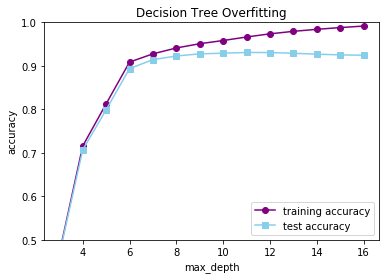

In [65]:
from sklearn.metrics import accuracy_score
max_depths = [3,4,5,6,7,8,9,10,11,12,13,14,15,16]
train_accu =[]
test_accu=[]

from sklearn import tree  # 또는 from sklearn import DecisionTreeClassifier
dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth=8, random_state=1)

for i in max_depths:
  dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth=i, random_state=1)
  dtc.fit(X_train_lda, y_train)
  y_train_pred=dtc.predict(X_train_lda) 
  y_test_pred=dtc.predict(X_test_lda)
  train_accu.append(accuracy_score(y_train, y_train_pred))
  test_accu.append(accuracy_score(y_test, y_test_pred))


plt.plot(range(3,17), train_accu, color="purple", marker='o', label="training accuracy")
plt.plot(range(3,17), test_accu, color="skyblue", marker='s', label ="test accuracy")
plt.legend(loc="best")
plt.ylabel("accuracy")
plt.xlabel("max_depth")
plt.title("Decision Tree Overfitting")
plt.ylim(0.5, 1.0)

참고로 다음 코드를 통해 트리를 눈으로 확인 가능 하다 

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.164886 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.164886 to fit



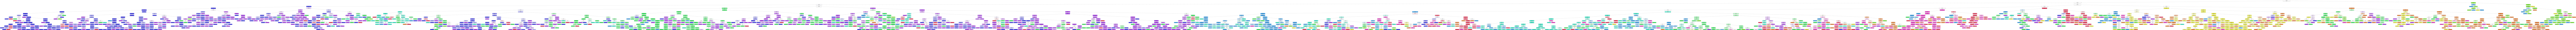

In [66]:
# Graphic
from pydotplus import graph_from_dot_data  # "pydotplus"는 따로 설치해야 함.
from sklearn.tree import export_graphviz
dot_data = export_graphviz(dtc, filled=True, rounded=True,
                           out_file=None)
graph = graph_from_dot_data(dot_data)
graph.write_png('tree.png')  # 현재경로(import os 엔터 os.getcwd()로 확인)에 저장


from IPython.display import Image 
Image(graph.create_png())   # Console 창에 결과 그림 출력

### 2-6 SVM & Kernel PCA

(0.5, 1.0)

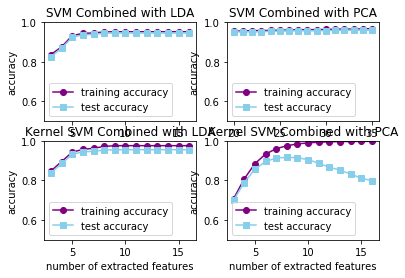

In [68]:
#LDA + SVM
from sklearn.metrics import accuracy_score
max_depths = [3,4,5,6,7,8,9,10,11,12,13,14,15,16]
train_accu =[]
test_accu=[]

from sklearn.svm import SVC #SVM함수의 호출
svm=SVC(kernel='linear',C=1.0,random_state=1)

for i in max_depths:
    lda=LDA(n_components=i) 
    X_train_lda=lda.fit_transform(X_train_std,y_train) # wine data에 의해 뽑힘.
    X_test_lda=lda.transform(X_test_std) 
    svm.fit(X_train_lda, y_train)
    y_train_pred=svm.predict(X_train_lda) 
    y_test_pred=svm.predict(X_test_lda)
    train_accu.append(accuracy_score(y_train, y_train_pred))
    test_accu.append(accuracy_score(y_test, y_test_pred))
    
plt.figure()
plt.subplot(2,2,1)
plt.plot(range(3,17), train_accu, color="purple", marker='o', label="training accuracy")
plt.plot(range(3,17), test_accu, color="skyblue", marker='s', label ="test accuracy")
plt.legend(loc="best")
plt.ylabel("accuracy")
plt.xlabel("number of extracted features")
plt.title("SVM Combined with LDA")
plt.ylim(0.5, 1.0)


#PCA + SVM
from sklearn.metrics import accuracy_score
max_depths = range(20,36)
train_accu =[]
test_accu=[]

from sklearn.svm import SVC #SVM함수의 호출
svm=SVC(kernel='linear',C=1.0,random_state=1)

for i in max_depths:
    lda=PCA(n_components=i) 
    X_train_lda=lda.fit_transform(X_train_std,y_train) 
    X_test_lda=lda.transform(X_test_std) 
    svm.fit(X_train_lda, y_train)
    y_train_pred=svm.predict(X_train_lda)
    y_test_pred=svm.predict(X_test_lda)
    train_accu.append(accuracy_score(y_train, y_train_pred))
    test_accu.append(accuracy_score(y_test, y_test_pred))


plt.subplot(2,2,2)
plt.plot(range(20,36), train_accu, color="purple", marker='o', label="training accuracy")
plt.plot(range(20,36), test_accu, color="skyblue", marker='s', label ="test accuracy")
plt.legend(loc="best")
plt.ylabel("accuracy")
plt.xlabel("number of extracted features")
plt.title("SVM Combined with PCA")
plt.ylim(0.5, 1.0)

# LDA + Kernel SVM
from sklearn.metrics import accuracy_score
max_depths = [3,4,5,6,7,8,9,10,11,12,13,14,15,16]
train_accu =[]
test_accu=[]

from sklearn.svm import SVC #SVM함수의 호출
ksvm=SVC(kernel='rbf',C=1.0,gamma=0.2,random_state=42)

for i in max_depths:
    lda=LDA(n_components=i) 
    X_train_lda=lda.fit_transform(X_train_std,y_train) 
    X_test_lda=lda.transform(X_test_std) 
    ksvm.fit(X_train_lda, y_train)
    y_train_pred=ksvm.predict(X_train_lda) 
    y_test_pred=ksvm.predict(X_test_lda)
    train_accu.append(accuracy_score(y_train, y_train_pred))
    test_accu.append(accuracy_score(y_test, y_test_pred))


plt.subplot(2,2,3)
plt.plot(range(3,17), train_accu, color="purple", marker='o', label="training accuracy")
plt.plot(range(3,17), test_accu, color="skyblue", marker='s', label ="test accuracy")
plt.legend(loc="best")
plt.ylabel("accuracy")
plt.xlabel("number of extracted features")
plt.title("Kernel SVM Combined with LDA")
plt.ylim(0.5, 1.0)

# PCA + Kernel SVM
from sklearn.metrics import accuracy_score
max_depths = range(3,17)
train_accu =[]
test_accu=[]

from sklearn.svm import SVC #SVM함수의 호출
ksvm=SVC(kernel='rbf',C=1.0,gamma=0.2,random_state=42)

for i in max_depths:
    lda=PCA(n_components=i) 
    X_train_lda=lda.fit_transform(X_train_std,y_train) 
    X_test_lda=lda.transform(X_test_std) 
    ksvm.fit(X_train_lda, y_train)
    y_train_pred=ksvm.predict(X_train_lda) 
    y_test_pred=ksvm.predict(X_test_lda)
    train_accu.append(accuracy_score(y_train, y_train_pred))
    test_accu.append(accuracy_score(y_test, y_test_pred))
    
plt.subplot(2,2,4)
plt.plot(range(3,17), train_accu, color="purple", marker='o', label="training accuracy")
plt.plot(range(3,17), test_accu, color="skyblue", marker='s', label ="test accuracy")
plt.legend(loc="best")
plt.ylabel("accuracy")
plt.xlabel("number of extracted features")
plt.title("Kernel SVM Combined with PCA")
plt.ylim(0.5, 1.0)

SVM의 경우 PCA를 통해 차원을 축소한 경우에 가장 정분류율이 높았으며, SVM 보다는 Kernel SVM을 사용했을 때 과적합 문제가 좀 더 심각했다. 따라서 여기서는 PCA를 통해 차원 축소를 하고 (35개 특성변수 추출) 튜닝을 하기로 했다. 계산시간이 많이 걸리는 편이었지만 분류 정확도가 높은 편이었다. 

In [69]:
from sklearn.decomposition import PCA

lda=PCA(n_components=35) 
X_train_lda=lda.fit_transform(X_train_std,y_train) 
X_test_lda=lda.transform(X_test_std) 

from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC #SVM함수의 호출
svm=SVC(random_state=1)

param_range = [0.001,0.01,0.1,1,10,100]
param_grid = [{'C': param_range, 'kernel': ['linear']}] 
gs = GridSearchCV(estimator=svm, param_grid=param_grid,
                  scoring='accuracy', cv=10)

gs = gs.fit(X_train_lda, y_train)
print("best accuracy : ",gs.best_score_)
print("best parameter : ", gs.best_params_)

best accuracy :  0.9620714285714286
best parameter :  {'C': 1, 'kernel': 'linear'}


In [70]:
import time
start = time.time() 


clf = gs.best_estimator_
clf.fit(X_train_lda, y_train)
print("train accuracy : ",clf.score(X_train_lda,y_train))
print("test accuracy : ",clf.score(X_test_lda, y_test))

print("time :", time.time() - start)

train accuracy :  0.9679761904761904
test accuracy :  0.9607777777777777
time : 29.126256942749023


### 2-7 Random Forest 

(0.5, 1.0)

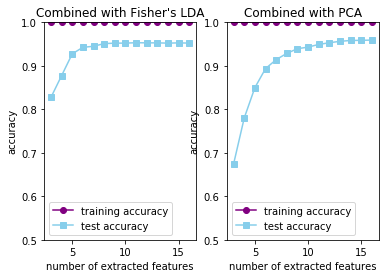

In [71]:
# LDA
from sklearn.metrics import accuracy_score
max_depths = [3,4,5,6,7,8,9,10,11,12,13,14,15,16]
train_accu =[]
test_accu=[]

from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(n_estimators=1000)

for i in max_depths:
    lda=LDA(n_components=i) 
    X_train_lda=lda.fit_transform(X_train_std,y_train)
    X_test_lda=lda.transform(X_test_std) 
    rfc.fit(X_train_lda, y_train)
    y_train_pred=rfc.predict(X_train_lda)
    y_test_pred=rfc.predict(X_test_lda)
    train_accu.append(accuracy_score(y_train, y_train_pred))
    test_accu.append(accuracy_score(y_test, y_test_pred))
    

plt.figure()
plt.subplot(1,2,1)
plt.plot(range(3,17), train_accu, color="purple", marker='o', label="training accuracy")
plt.plot(range(3,17), test_accu, color="skyblue", marker='s', label ="test accuracy")
plt.legend(loc="best")
plt.ylabel("accuracy")
plt.xlabel("number of extracted features")
plt.title("Combined with Fisher's LDA")
plt.ylim(0.5, 1.0)

# PCA 
from sklearn.metrics import accuracy_score
max_depths = range(3,17)
train_accu =[]
test_accu=[]

from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(n_estimators=1000)

for i in max_depths:
    pca=PCA(n_components=i)
    X_train_pca = pca.fit_transform(X_train_std,y_train) 
    X_test_pca=pca.transform(X_test_std) 
    rfc.fit(X_train_pca, y_train)
    y_train_pred=rfc.predict(X_train_pca) 
    y_test_pred=rfc.predict(X_test_pca)
    train_accu.append(accuracy_score(y_train, y_train_pred))
    test_accu.append(accuracy_score(y_test, y_test_pred))

plt.subplot(1,2,2)
plt.plot(range(3,17), train_accu, color="purple", marker='o', label="training accuracy")
plt.plot(range(3,17), test_accu, color="skyblue", marker='s', label ="test accuracy")
plt.legend(loc="best")
plt.ylabel("accuracy")
plt.xlabel("number of extracted features")
plt.title("Combined with PCA")
plt.ylim(0.5, 1.0)
    

랜덤 포레스트 모델의 경우 두 차원 축소간의 정분류율이 거의 차이가 나지 않았다. 따라서 Fisher’s LDA를 통한 차원축소를 하기로 한다(n_componets= 9). 또한 랜덤 포레스트 모형은 다른 모델에 비해 과적합의 정도가 심하다는 것을 알 수 이었다. 랜덤 포레스트의 경우 따로 튜닝을 거치지 않았으며, fit과 prediction 을 위한 계산시간은 총 약 131초가 걸렸으며, 정분류율은 train과 test 데이터 각각 1.0 과 0.95206 이었으므로, 과적합문제가 있을지라도 성능은 매우 우수했다. 

### 2-8 Gradient Boosting

Gradient Boosting의경우 따로 차원축소 방법에 대한 비교를 하진 않았으며 fisher’s LDA를 통한 차원축소(n_components=9)를 이용했다(앙상블도 마찬가지). fit에서 prediction 까지 시간은 408 초 가량 소비되었으며, 정분류율은 train과 test 셋 각각 1.0과 0.9516 이었다. 이경우에도 과적합은 다른 모델보다는 심한 편이었다.



In [72]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda=LDA(n_components=9) 
X_train_lda=lda.fit_transform(X_train_std,y_train) 
X_test_lda=lda.transform(X_test_std) 


start = time.time() 

from sklearn.ensemble import GradientBoostingClassifier
gbrg=GradientBoostingClassifier(n_estimators=120, max_depth=8)
gbrg.fit(X_train_lda, y_train)

print("time :", time.time() - start)

time : 494.1237123012543


In [73]:
import time
start = time.time() 

y_train_pred=gbrg.predict(X_train_lda) # kernel SVM을 이용한 train set의 y 예측치 구하기
y_test_pred= gbrg.predict(X_test_lda)  #test set의 y예측치 구하기

print('Misclassified training samples: %d' %(y_train!=y_train_pred).sum()) #오분류 데이터 갯수 확인
print('Misclassified test samples: %d' %(y_test!=y_test_pred).sum()) #오분류 데이터 갯수 확인

print("time :", time.time() - start)

Misclassified training samples: 0
Misclassified test samples: 886
time : 2.744567394256592


In [74]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_train, y_train_pred)) # train data에 대한 accuracy
print(accuracy_score(y_test, y_test_pred)) # test data에 대한 accuracy


# 분류 결과
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_test_pred))  # 각 행은 setosa, versicolor, virginica

1.0
0.9507777777777778
[[1714   44    5    9    2    0    1   10   13    2]
 [  20 1756    1   12    0    5    0    2    1    3]
 [   6    2 1775    5    0   11    0    0    0    1]
 [   8    0    2 1688   15   14   10   61    1    1]
 [   2    0    0   15 1730   32    1    2    1   17]
 [   1    9   11   14   25 1727    2    0    9    2]
 [   2    0    0   23    1    0 1653  118    1    2]
 [   4    4    0   76    9    2  103 1599    0    3]
 [  19    3    4    5    2    1    1    0 1755   10]
 [   4    1    0    4   24    2   21   13   14 1717]]


첨언) light GBM을 실행할 수 있는 lightgbm 팩키지를 사용해 모델을 적합시킬수도 있다. 경험상으로 xgboost보다 계산속도가 빠른 경우가 많으며, loss 값을 iteration 마다 볼 수 있으므로, loss가 떨어지는 형태를 보고 파라미터 설정이 적절하지 않다고 느낄 시 미리 중지 할 수 있다는 장점이 있었다. 계산시간은 약 204초가 걸렸으며 train 과 test셋의 정분류율은 각각 1.0과 0.954 로 오히려 Gradient boosting 보다 더 나았다. 다음은 코드와 아웃풋의 예시이다. 


In [75]:
import lightgbm as lgb 
params = {'learning_rate': 0.1, 
          'max_depth': 4 ,
          'boosting': 'gbdt', 
          'objective': 'multiclass', 
          'metric': 'multi_error', 
          'is_training_metric': True,
          'num_leaves': 30, 
          'feature_fraction': 0.7, 
          'bagging_fraction': 0.7, 
          #'bagging_freq':8, 
          #'scale_pos_weight' :1.3,
          #'lambda_l1' : 10,
         # 'cat_smooth' : 10,   
          "num_class" :10 ,
          # 큰 값 입력시 카테고리변수 가중치 감소
          'seed':123}
train_ds = lgb.Dataset(X_train_lda, label =y_train) 
test_ds = lgb.Dataset(X_test_lda, label = y_test) 

import time
start = time.time() 
model = lgb.train(params, train_ds, 10000, test_ds, verbose_eval=100, early_stopping_rounds=500)

y_train_pred= model.predict(X_train_lda)
y_test_pred = model.predict(X_test_lda)


print("time :", time.time() - start)

Training until validation scores don't improve for 500 rounds.
[100]	valid_0's multi_error: 0.0500556
[200]	valid_0's multi_error: 0.0480556
[300]	valid_0's multi_error: 0.0477222
[400]	valid_0's multi_error: 0.0475
[500]	valid_0's multi_error: 0.0471111
[600]	valid_0's multi_error: 0.047
[700]	valid_0's multi_error: 0.0468333
[800]	valid_0's multi_error: 0.0469444
[900]	valid_0's multi_error: 0.0466667
[1000]	valid_0's multi_error: 0.0468333
[1100]	valid_0's multi_error: 0.0467222
[1200]	valid_0's multi_error: 0.0467222
[1300]	valid_0's multi_error: 0.0466667
[1400]	valid_0's multi_error: 0.0465556
[1500]	valid_0's multi_error: 0.0467222
[1600]	valid_0's multi_error: 0.0465
[1700]	valid_0's multi_error: 0.0462222
[1800]	valid_0's multi_error: 0.0464444
[1900]	valid_0's multi_error: 0.0460556
[2000]	valid_0's multi_error: 0.0463333
[2100]	valid_0's multi_error: 0.0465
[2200]	valid_0's multi_error: 0.0463333
[2300]	valid_0's multi_error: 0.0463333
[2400]	valid_0's multi_error: 0.0465
[2

첨언2) 캣부스트 또한 매우 간편하게 쓸 수 있으며, lightgbm 보다도 성능이 뛰어난 것으로 확인되고 있다. 더욱 좋은점은 파라미터 튜닝을 수동으로 하지 않더라도 매우 준수한 성능을 보인다는 것이다. ( 튜닝을 하더라도 튜닝에 따르는 시간소모에 비해 유의미한 성능향상을 경험하지 못함) 


In [78]:
#!pip install catboost
from catboost import CatBoostClassifier

n_rounds = 10000
n_splits = 15

cat_params = {
        'n_estimators': n_rounds,
        #'learning_rate': 0.01,
        'eval_metric': 'MultiClass',
        'loss_function': 'MultiClass',
        'random_seed': 42,
        'metric_period': 500,
        'od_wait': 500,
        'task_type': 'GPU',
        'l2_leaf_reg' : 4,
        'depth': 9,
        "random_strength" : 1
       # "eaf_estimation_method":'Newton'
    }

model = CatBoostClassifier(**cat_params)
model.fit(X_train_lda, y_train, eval_set = (X_test_lda, y_test))

0:	learn: 2.1013322	test: 2.1045692	best: 2.1045692 (0)	total: 32.5ms	remaining: 5m 24s
500:	learn: 0.0956170	test: 0.1476720	best: 0.1476720 (500)	total: 13.1s	remaining: 4m 8s
1000:	learn: 0.0652045	test: 0.1380355	best: 0.1380355 (1000)	total: 25.7s	remaining: 3m 50s
1500:	learn: 0.0483901	test: 0.1365111	best: 0.1364477 (1451)	total: 38.3s	remaining: 3m 37s
2000:	learn: 0.0376483	test: 0.1366722	best: 0.1363540 (1659)	total: 50.7s	remaining: 3m 22s
bestTest = 0.1363540039
bestIteration = 1659
Shrink model to first 1660 iterations.


### 2-9 Ensemble Model 

대부분의 모델에서 Fisher’s LDA에 의한 차원축소가 효과적이었으므로 Fisher’s LDA를 통해 뽑은 새로운 특성변수를 사용하기로 한다. 먼저 위 모델 중에서 성능이 좋은 편에 속했던 SVM과 Random Forest, Gradient Boosting을 앙상블 하였다. 또한 성능이 상대적으로 안 좋은 모델이라도 앙상블 했을 때 정분류율이 올라가는지 궁금하여 Classification Tree와 Naïve Bayes 모델, 그리고 QDA를 앙상블 해보았다. 

In [0]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression    
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

#### 2-9-1 SVM, Random Forest, Gradient Boosting


In [80]:
rfc = RandomForestClassifier(n_estimators=100)
svm = SVC(C=1, kernel="linear")
gbc = GradientBoostingClassifier()
voting_high=VotingClassifier(estimators=[('rfc', rfc), ('svc', svm), ('gbc', gbc)],voting='hard') 



from sklearn.metrics import accuracy_score
for cl in (rfc, svm, gbc, voting_high):
    cl.fit(X_train_lda, y_train)
    y_pred = cl.predict(X_test_lda) 
    print(cl.__class__.__name__, accuracy_score(y_test, y_pred)) 

RandomForestClassifier 0.9516111111111111
SVC 0.9461666666666667
GradientBoostingClassifier 0.9456111111111111
VotingClassifier 0.9505


In [81]:
from sklearn.metrics import accuracy_score

y_pred2 = voting_high.predict(X_test_lda)
print(accuracy_score(y_test, y_pred2))

0.9505


#### 2-9-2 Classification Tree, Naïve Bayes, QDA

In [82]:
tree = DecisionTreeClassifier(max_depth = 11)
Gnb = GaussianNB()
qda =  QuadraticDiscriminantAnalysis()
voting_low=VotingClassifier(estimators=[('tree', tree), ('Gnb', Gnb), ('qda', qda)],voting='hard') # hard로 주면 많이 뽑힌대로 예측. soft는 확률을 기준으로 예측


from sklearn.metrics import accuracy_score
for cl in (tree, Gnb, qda, voting_low):
    cl.fit(X_train_lda, y_train)
    y_pred = cl.predict(X_test_lda) 
    print(cl.__class__.__name__, accuracy_score(y_test, y_pred)) 


DecisionTreeClassifier 0.9307222222222222
GaussianNB 0.9357777777777778
QuadraticDiscriminantAnalysis 0.9428888888888889
VotingClassifier 0.9426111111111111


In [83]:
from sklearn.metrics import accuracy_score

y_pred = voting_low.predict(X_test_lda)
print(accuracy_score(y_test, y_pred))

0.9426111111111111


예상외로 두 가지 경우 모두 가장 성능이 좋았던 모델은 앙상블이 아니었다. 2-9-1 모델에서는 랜덤 포레스트 모델이 가장 정분류율이 높았으며, 2-9-2 모델에서는 QDA 모델에서 가장 높았다. 하지만 앙상블 모델과의 차이가 매우 미미하며, 앙상블 모델이 확실히 나머지 모델보다는 성능이 좋았다는 사실을 알 수 있었다. 따라서 앙상블 모델을 사용할 때 정분류율을 항상 높이는 것은 아니지만, 어떤 모델을 써야 할지 모르는 상황에서는 확실히 좋은 전략이라고 결론 내렸다.

## 3. 결론



*   특성변수의 수가 너무 많다면 PCA나 Fisher’s LDA로 차원 축소하는 것이 정확도와 계산시간을 개선할 수 있다. (예 : 나이브 베이즈 모델)

*  	특성변수의 수가 너무 많다면 Fisher’s LDA가 좀더 차원축소를 효과적으로 할 수 있는 편이지만, 분류 정확도를 고려한다면 PCA를 택해 특성변수를 많이 사용하는 것이 좋은 경우 또한 있었다. (예 : KNN). 또한 Fisher’s LDA를 통해 차원 축소한 변수들의 수를 늘리는 전략은 PCA에서 보다 한계점이 명확했다.

* 	분류 정확도가 가장 높은 모형은 PCA를 활용한 SVM이었고, 랜덤포레스트와 GBM 도 성능이 좋았다. 

*  트리모델, 랜덤포레스트, Kernel PCA, KNN은 과적합 문제가 다른 모델보다 심한 편이었다.

